# Monopoly and Markov Chains


The goal of this project is to use Markov chains to model the game of Monopoly. We aim to answer some simple questions about the game:
- What are the locations visited the most often? 
- After how many turns is the game at an equilibrium?
- Is there a better strategy? Should one always build hotels? Can we stick to houses?

To ease the analysis we will simplify some of the rules by simplifying the rules to get out of jail, and neglect the effect of the "Chance" and the "Community chest" cards. We will also consider players that always stick to the same strategy.

Most of the following analysis were motivated by two articles from Ian stewarts in the Scientific American, (reproductions from the articles are linked [here](http://www.math.yorku.ca/Who/Faculty/Steprans/Courses/2042/Monopoly/Monopoly.html) or available on the course page).



## Summary of the game

Those short explanations of the game are taken from [this website](http://www.durangobill.com/Monopoly.html). You can as well check the rules on the wikipedia page ([english](https://en.wikipedia.org/wiki/Monopoly_(game)), [german](https://de.wikipedia.org/wiki/Monopoly)). 

### Rules of the game

#### Dice Rolls: 

 - A player rolls **a pair of dice** and moves his board piece (token) clockwise around the board. The number of board spaces he moves is equal to the sum of the dice. 
 - If he stops on a "Chance" or "Community Chest" board space, he picks up a card from the indicated stack, and if instructed, moves his token to a new location. 
 - If he had doubles, he repeats this process. 
 - However, if he has three doubles in a row, he instead goes directly to Jail.

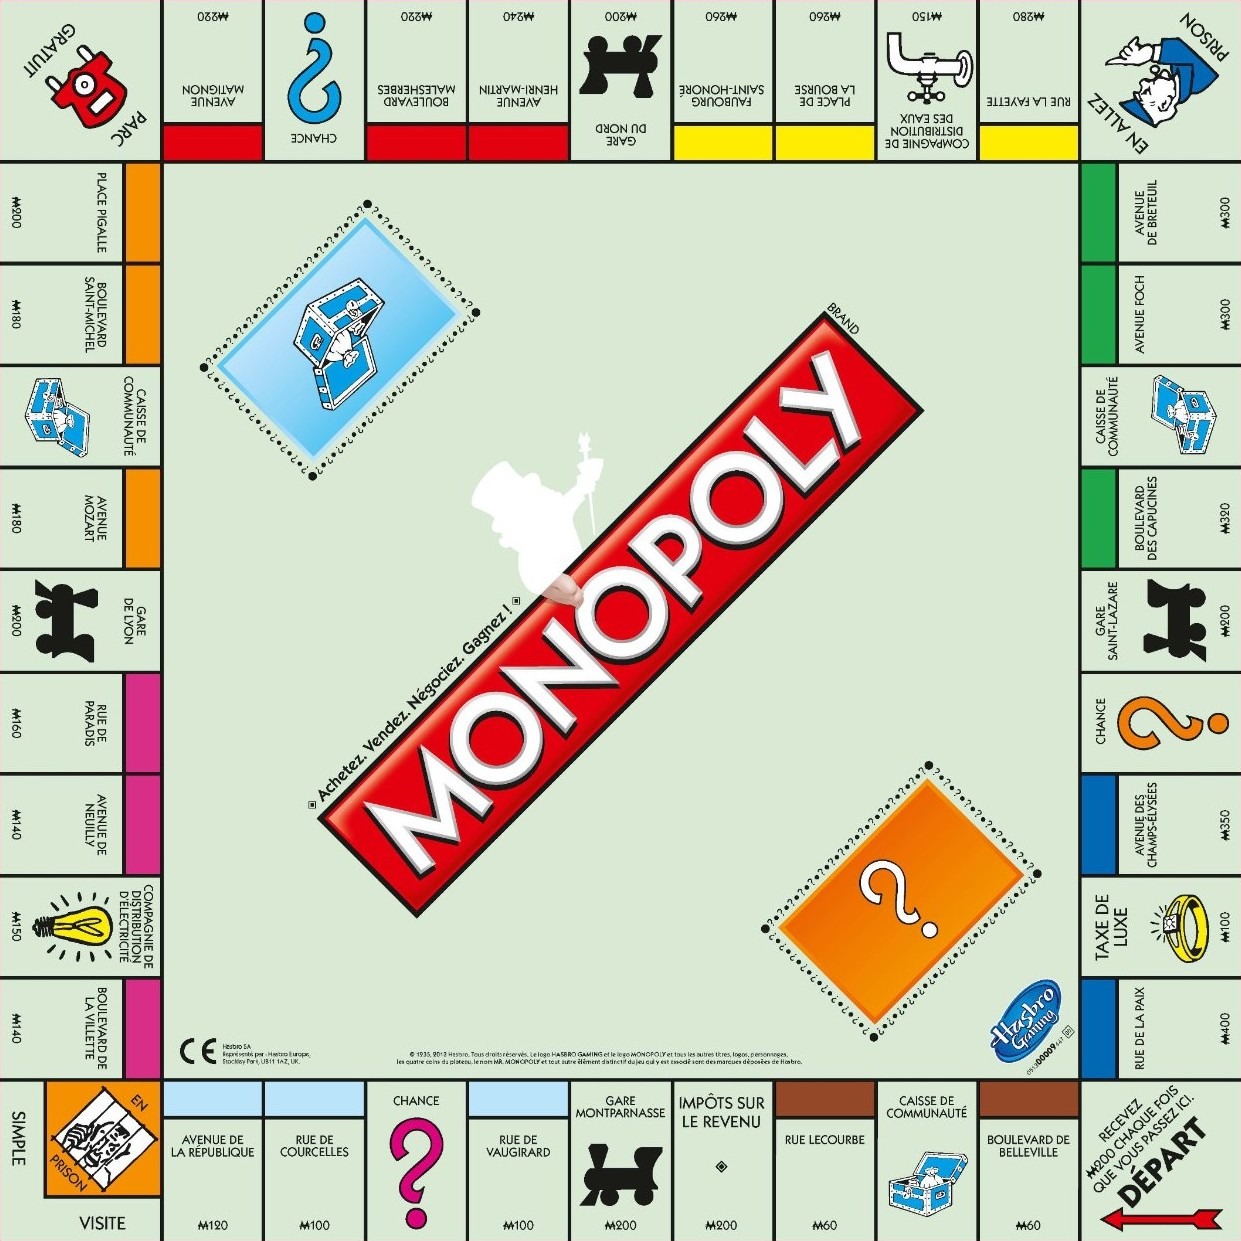



#### Going to Jail: 

If a player is instructed to go to Jail (at any point during his turn), his turn ends regardless of the doubles status. The player will stay at most 3 turns in Jail. He can go out of jail in one of the following manner:
- Paying is way out (50\$). In this case the token goes to "Just visiting" and the player can throw is dice as usual. 
- Using a Chance card. This is similar as paying 50\$.
- Rolling the dice. If there is a double, the player can go out and moves forwards of the number obtained with the dice. Note that in this case the player cannot roll the dice again (the double was "used" to get out of jail).


After the third turn, if the player does not get a double, he *must* pay 50\$ and moves of the number of spaces obtained with the dice.


## 1. Setting up the Markov Chain

In this first part we will set up the parameters for a Markov chain that models the movements of the token of the board from turn to turn. 
We make the following simplification to the rules: 
- Double with the Dice does not allow a second roll.
- We do not consider the cards in the Chance and Community chest slots.
- When getting into Jail, the player always pays 50\$ at the first turn to get out of jail.


We start by constructing the markov chain.

In [ ]:
!uv pip install pandas
!uv pip install tqdm
!uv pip install --upgrade plotly
!uv pip install "plotly[kaleido]"
!uv pip install imageio
!uv pip install pycairo
!uv pip install cairosvg

In [2]:
import numpy as np
import plotly.express as px

#Sorry the street names are in French! 
#you can replace it with the colors as in the table file
squares = [
"Départ",
"Boulevard de Belleville",
"Caisse de Communauté-1",
"Rue Lecourbe",
"Impôts sur le Revenu",
"Gare Montparnasse",
"Rue de Vaugirard",
"Chance-1",
"Rue de Courcelles",
"Avenue de la République",
"Visite de Prison",
"Boulevard de la Villette",
"Compagnie de Distribution d Électricité",
"Avenue de Neuilly",
"Rue de Paradis",
"Gare de Lyon",
"Avenue Mozart",
"Caisse de Communauté-2",
"Boulevard Saint-Michel",
"Place Pigalle",
"Parc Gratuit",
"Avenue Matignon",
"Chance-2",
"Boulevard Malesherbes",
"Avenue Henri-Martin",
"Gare du Nord",
"Faubourg Saint-Honoré",
"Place de la Bourse",
"Compagnie de Distribution des Eaux",
"Rue La Fayette",
"Allez en Prison",
"Avenue de Breteuil",
"Avenue Foch",
"Caisse de communauté-3",
"Boulevard des Capucines",
"Gare Saint-Lazare",
"Chance-3",
"Avenue des Champs-Élysées",
"Taxe de Luxe",
"Rue de la Paix"]

brown = [1,3]
light_blue = [6,8,9]
pink = [11, 13, 14]
orange = [16, 18, 19]
red = [21, 23,24]
yellow = [26, 27, 29]
green = [31,32, 34]
blue = [37, 39]

# squares += ["Prison"]
nsquares = len(squares)

colors = np.array(['hsv(0,0%,50%)               ']*nsquares)
# colors = np.array(['hsv(0,100%,100%)']*nsquares)
colors[brown] = 'hsv(30,75%,65%)'
colors[light_blue] = 'hsv(195,26%,90%)'
colors[pink] = 'hsv(350,25%,100%)'
colors[orange] = 'hsv(39,100%,100%)'
colors[red] ='hsv(0,100%,100%)'
colors[yellow] = 'hsv(60,100%,100%)'
colors[green] = 'hsv(120,100%,50%)'
colors[blue] = 'hsv(240,100%,100%)'

##Some easy links
dict_squares = dict((x, i) for i,x in enumerate(squares))
iprison = dict_squares["Allez en Prison"] ## This square is in fact never visited 
ivisite = dict_squares["Visite de Prison"]

#Construct a 12 element array with all dice probabilities
TwoDices = np.zeros(12, dtype=np.float64)
TwoDices = np.array([len([(j,k) for j in range(1,7) for k in range(1,7) if j + k == i]) / 36 for i in range(2,13)])
print(TwoDices)


## The initial probability. Note that we set a vector to allow matrix product computations 
## afterwards.
pi=np.zeros((1, nsquares))
pi[0,0] = 1
##Set up the Transition Matrix
A = np.zeros((nsquares, nsquares), dtype=np.float64)

###YOUR CODE HERE
for square in dict_squares:
    for j in range(2,13):
        i = dict_squares[square]
        # if square == "Prison":
        #     A[i][(ivisite + j) % (nsquares - 1)] += TwoDices[j - 2]
        if i == iprison:
            continue
        if (i + j) % nsquares == iprison:
            A[i][ivisite] += TwoDices[j - 2]
        else:
            A[i][(i+j) % nsquares] += TwoDices[j - 2]

fig = px.imshow(A, text_auto=True)
fig.show()

for i in range(nsquares):
    s = np.sum(A[i])
    if s != 1.0:
        print(i, squares[i], s)


[0.02777778 0.05555556 0.08333333 0.11111111 0.13888889 0.16666667
 0.13888889 0.11111111 0.08333333 0.05555556 0.02777778]


30 Allez en Prison 0.0



## 2. After a few game turns.

Compute the probability of occupation on the board after a few turns of games. You will produce a set of histograms in the like of the one below


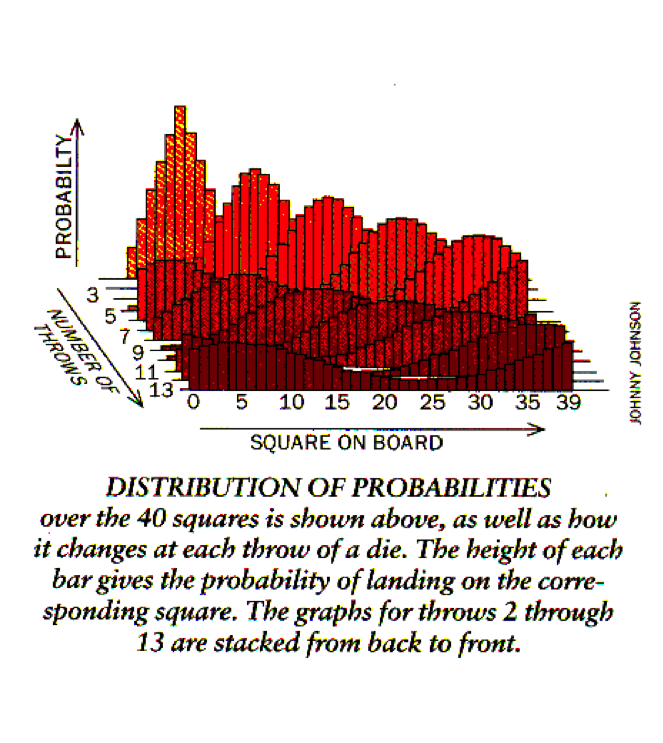


In [68]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

In [75]:
board_turn_3 = (pi @ np.linalg.matrix_power(A, 3)).flatten()
board_turn_7 = (pi @ np.linalg.matrix_power(A, 7)).flatten()
board_turn_13 = (pi @ np.linalg.matrix_power(A, 13)).flatten()
board_turn_100 = (pi @ np.linalg.matrix_power(A, 100)).flatten()


##Your plotting command here
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=["Turn 3", "Turn 7", "Turn 13", "Turn 100"])

fig.add_trace(go.Bar(x = squares, y = board_turn_3, marker = dict(color=colors.tolist())), row=1, col=1)
fig.add_trace(go.Bar(x = squares, y = board_turn_7, marker = dict(color=colors.tolist())), row=2, col=1)
fig.add_trace(go.Bar(x = squares, y = board_turn_13, marker = dict(color=colors.tolist())),row=3, col=1)
fig.add_trace(go.Bar(x = squares, y = board_turn_100, marker = dict(color=colors.tolist())),row=4, col=1)

fig.update_layout(
    height = 1200
)
fig.show()

In [76]:
turns = []
boards = []

for i in range(1, 22, 2):
    turns.append(i)
    boards.append(pi @ np.linalg.matrix_power(A, i))

fig = go.Figure()

for turn, board in zip(turns, boards):
    fig.add_trace(
        go.Scatter3d(
            x=np.full(nsquares, turn),
            y= np.arange(nsquares),
            z= board.flatten(),
            mode="lines+markers",
            name=f"Turn {turn}"
        )

    )

fig.update_layout(
    scene=dict(
        xaxis_title="Turns",
        yaxis_title="Squares",
        zaxis_title="Probabilities"
    )
)


fig.show()

## 3.a Computing the stationary distribution


Compute the stationary distribution $\mu$ of the Markov Chain, by using either one of the following properties:
 - $\lim_{n\rightarrow \infty} A^n = \mu$
 - $\mu \cdot A = \mu$. In other word $\mu$ is the eigenvector associated with the eigenvalue $1$.
 
Both can be obtained with the linear algebra functions of numpy. 

Verify that you get something similar to this image (this will not be exactly the same as it was obtained from a more detailled model):

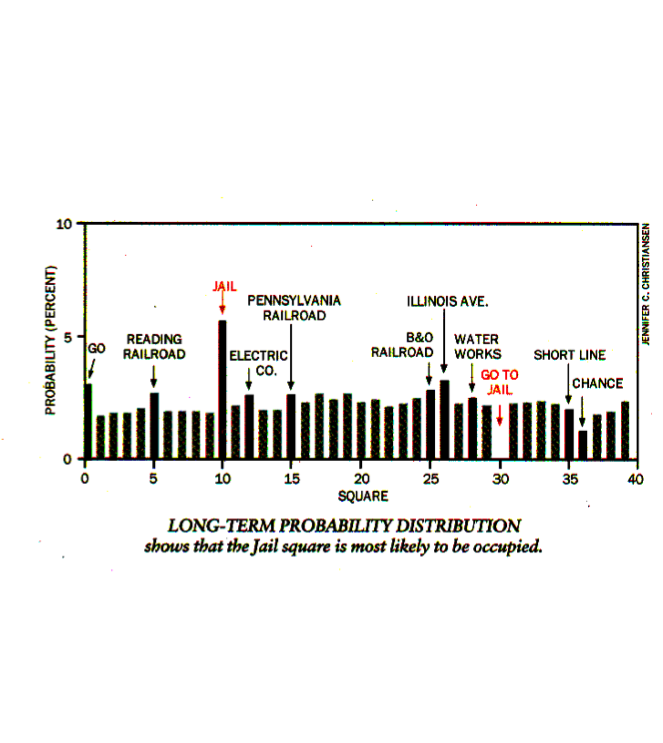


Under the assumption that $2000 \approx \infty$

In [ ]:
#np.linalg.matrix_power is one function you can use

stationary = np.linalg.matrix_power(A, 2000)[0] # same as pi @
fig = go.Figure([go.Bar(x = squares, y = stationary, marker = dict(color=colors.tolist()))], layout={"height":700})
fig.show()

In [ ]:
n = 1
maxTurns = 20
for i in range(maxTurns):
    mu = pi @ np.linalg.matrix_power(A, n)

    if np.allclose(mu @ A, mu, atol=1e-10):
        print(f"Power Level:{n}")
        print(mu)
        fig = px.bar(x=np.arange(nsquares), y=mu.flatten(), title="Stationary Monopoly")
        fig.show()
        break

    n *= 10

Can you explain why some locations are more visited than others?

Because there is a jail in the Monopoly game, the probabilities are not completely identical to those of a typical dice roll. The jail square has a significantly higher probability due to the position change, as there are two ways to land on this square. The squares after prison also have a slightly higher probability of being landed on, as players coming out of prison land on them, compared to the squares before prison. We can observe this especially well looking at Caisse de Communauté-2, the seventh square after the prison, which is the most likely outcome of the sum of two dice.

## 3b. Convergence to the stationnary distribution

Use the successive powers of the matrix to determine the number of turns after which the chain converged to the stationary distribution (_e.g._ when the difference between the distribution of the rows of the matrix and the stationnary distribution is below 1%)



In [77]:
from copy import deepcopy

In [81]:
# Your code here
def total_variation(d1, d2):
    return 0.5 * (np.sum(np.abs(d1 - d2)))

power = deepcopy(A)

for i in range(1, 2000):
    power = power @ A
    tv = total_variation(pi @ power, stationary)
    if tv < (1 / pow(nsquares,2)):
        print(f"Convergence after {i} iterations with maximal total variation dist of {tv}")
        break

Convergence after 55 iterations with maximal total variation dist of 0.0005395059294956827


## 3c. Evaluating investments   

We provide in attachment a table with all the incomes associated to the various properties of the board. Let's see how we can use that information to understand how to evaluate the various real estate investments on the board.

For each square $k$ of the monopoly, we thus know the cost $c_{k}$ of the property, the price $h_k$ of an house and the rent $r_{k,h}$ with $h$ house. The total cost of a property with $h$ house is $c_{k,h}= c_k + h\cdot h_k$ 

1. Verify that the expected income per opponent turn on square $k$ is $i_{k,h} = \mu_k \cdot r_{k,h}$ and compute this value for all square and all number of houses. For instance a property where an opponent as 5% chance of landing with a rent of 100\\$ provides an expected income per turn of 5\\$.

2. Now an interesting quantity is the expected number of opponents turns before we are able to return on our investment with buying the property. For instance if the property mentionned in q.1 costed 50\\$, given that we expect to earn 5\\$ per turn with no house, our average waiting time before returning on our investment will be after $\frac{50}{5}=10$ opponent turns. Verify that the general formula for this value is:
$$
e_{k,h} = \frac{c_{k,h}} {i_{k,h}}
$$

3. compute $e_{k,h}$ for all square and all number of houses and check the most rentable properties, as a function of the number of houses.

4. (optional). Compute the expected number of turns to get a return of investment on a given color.


5. A classical recommendation for Monopoly is to buy orange properties, can you back up this claim?

In [8]:
# read monopoly square data in Monopoly_square_data.csv

monopoly_data = pd.read_csv("Data/Monopoly_squares_data.csv")

possible_buildings = ["RENT_empty_property","RENT_1house","RENT_2houses","RENT_3houses","RENT_4houses","RENT_hotel"]

house_costs = monopoly_data["house_cost"]
property_costs = monopoly_data["Cost"]

def cost_houses(square, num_houses):
    return house_costs[square] + num_houses * house_costs[square]

# Compute i_k_h 
income = np.zeros((nsquares, len(possible_buildings)))
for square in squares:
    i = dict_squares[square]
    if monopoly_data["Cost"][i] == np.nan:
        continue
    for j,name in enumerate(possible_buildings):
        income[i][j] = stationary[i] * monopoly_data[name][i]

# Compute e_k_h
expected_roi = np.zeros((nsquares, len(possible_buildings)))
for square in squares:
    i = dict_squares[square]
    if np.isnan(monopoly_data["Cost"][i]):
        for j in range(len(possible_buildings)):
            expected_roi[i][j] = np.nan
        continue
    for j,name in enumerate(possible_buildings):
        expected_roi[i][j] = cost_houses(i,j) / income[i][j]


property_squares = [i for i in range(nsquares) if not np.isnan(expected_roi[i][0])]
property_colors = colors[property_squares]
for j in range(len(possible_buildings)):
    property_roi = [expected_roi[i][j] for i in property_squares]
    fig = go.Figure([go.Bar(x = np.array(squares)[property_squares], y = property_roi, marker = dict(color=property_colors.tolist()))])
    fig.show()



In [83]:
import pandas as pd
# read monopoly square data in Monopoly_square_data.csv
costs_squares = pd.read_csv("./Data/Monopoly_squares_data.csv")
costs_squares

Slot   Cost  RENT_empty_property  RENT_color_set  RENT_1house  \
0                Go    NaN                  NaN             NaN          NaN   
1           Brown 1   60.0                  2.0             4.0         10.0   
2   Community Chest    NaN                  NaN             NaN          NaN   
3           Brown 2   60.0                  4.0             8.0         20.0   
4        Income Tax    NaN                  NaN             NaN          NaN   
5        Railroad 1  200.0                  NaN             NaN         25.0   
6      Light Blue 1  100.0                  6.0            12.0         30.0   
7            Chance    NaN                  NaN             NaN          NaN   
8      Light Blue 2  100.0                  6.0            12.0         30.0   
9      Light Blue 3  120.0                  8.0            16.0         40.0   
10             Jail    NaN                  NaN             NaN          NaN   
11           Pink 1  140.0                 10.0            20.0         50.0   
12        Utility 1  150.0                 28.0            70.0          NaN   
13           Pink 2  140.0                 10.0            20.0         50.0   
14           Pink 3  160.0                 12.0            24.0         60.0   
15       Railroad 2  200.0                  NaN             NaN         25.0   
16         Orange 1  180.0                 14.0            28.0         70.0   
17  Community Chest    NaN                  NaN             NaN          NaN   
18         Orange 2  180.0                 14.0            28.0         70.0   
19         Orange 3  200.0                 16.0            32.0         80.0   
20     Free Parking    NaN                  NaN             NaN          NaN   
21            Red 1  220.0                 18.0            36.0         90.0   
22           Chance    NaN                  NaN             NaN          NaN   
23            Red 2  220.0                 18.0            36.0         90.0   
24            Red 3  240.0                 20.0            40.0        100.0   
25       Railroad 3  200.0                  NaN             NaN         25.0   
26         Yellow 1  260.0                 22.0            44.0        110.0   
27         Yellow 2  260.0                 22.0            44.0        110.0   
28        Utility 2  150.0                 28.0            70.0          NaN   
29         Yellow 3  280.0                 24.0            48.0        120.0   
30       Go To Jail    NaN                  NaN             NaN          NaN   
31          Green 1  300.0                 26.0            52.0        130.0   
32          Green 2  300.0                 26.0            52.0        130.0   
33  Community Chest    NaN                  NaN             NaN          NaN   
34          Green 3  320.0                 28.0            56.0        150.0   
35       Railroad 4  200.0                  NaN             NaN         25.0   
36           Chance    NaN                  NaN             NaN          NaN   
37      Dark Blue 1  350.0                 35.0            70.0        175.0   
38       Luxury Tax    NaN                  NaN             NaN          NaN   
39      Dark Blue 2  400.0                 50.0           100.0        175.0   

    RENT_2houses  RENT_3houses  RENT_4houses  RENT_hotel  house_cost  
0            NaN           NaN           NaN         NaN         NaN  
1           30.0          90.0         160.0       250.0        50.0  
2            NaN           NaN           NaN         NaN         NaN  
3           60.0         180.0         320.0       450.0        50.0  
4            NaN           NaN           NaN         NaN         NaN  
5           50.0         100.0         200.0         NaN         NaN  
6           90.0         270.0         400.0       550.0        50.0  
7            NaN           NaN           NaN         NaN         NaN  
8           90.0         270.0         400.0       550.0        50.0  
9          100.0        

In [107]:
# Compute i_k_h
i_k_h = costs_squares.iloc[:, [2,3,4, 5, 6, 7, 8]].mul(stationary.flatten()[:40], axis=0)
i_k_h

RENT_empty_property  RENT_color_set  RENT_1house  RENT_2houses  \
0                   NaN             NaN          NaN           NaN   
1              0.046236        0.092472     0.231181      0.693542   
2                   NaN             NaN          NaN           NaN   
3              0.094288        0.188575     0.471438      1.414313   
4                   NaN             NaN          NaN           NaN   
5                   NaN             NaN     0.575142      1.150285   
6              0.137606        0.275213     0.688032      2.064097   
7                   NaN             NaN          NaN           NaN   
8              0.138024        0.276049     0.690122      2.070367   
9              0.184632        0.369264     0.923161      2.307902   
10                  NaN             NaN          NaN           NaN   
11             0.231380        0.462760     1.156901      3.470703   
12             0.668159        1.670398          NaN           NaN   
13             0.245837        0.491675     1.229186      3.687559   
14             0.303967        0.607933     1.519833      4.559499   
15                  NaN             NaN     0.653192      1.306384   
16             0.377972        0.755945     1.889862      5.399607   
17                  NaN             NaN          NaN           NaN   
18             0.385729        0.771459     1.928647      5.510420   
19             0.436286        0.872573     2.181432      5.998938   
20                  NaN             NaN          NaN           NaN   
21             0.483875        0.967749     2.419373      6.720481   
22                  NaN             NaN          NaN           NaN   
23             0.475706        0.951412     2.378531      6.607030   
24             0.535993        1.071986     2.679965      8.039895   
25                  NaN             NaN     0.674858      1.349715   
26             0.595443        1.190886     2.977215      8.931644   
27             0.595204        1.190407     2.976018      8.928053   
28             0.755886        1.889714          NaN           NaN   
29             0.646103        1.292207     3.230517      9.691552   
30                  NaN             NaN          NaN           NaN   
31             0.698412        1.396823     3.492058     10.476173   
32             0.679566        1.359133     3.397832     10.193495   
33                  NaN             NaN          NaN           NaN   
34             0.690745        1.381489     3.700417     11.101251   
35                  NaN             NaN     0.596808      1.193616   
36                  NaN             NaN          NaN           NaN   
37             0.771164        1.542327     3.855818     11.016622   
38                  NaN             NaN          NaN           NaN   
39             1.136605        2.273210     3.978118     11.366051   

    RENT_3houses  RENT_4houses  RENT_hotel  
0            NaN           NaN         NaN  
1       2.080627      3.698892    5.779519  
2            NaN           NaN         NaN  
3       4.242938      7.543002   10.607346  
4            NaN           NaN         NaN  
5       2.300569      4.601138         NaN  
6       6.192291      9.173765   12.613927  
7            NaN           NaN         NaN  
8       6.211102      9.201633   12.652245  
9       6.923707     10.385560   13.847414  
10           NaN           NaN         NaN  
11     10.412108     14.461261   17.353514  
12           NaN           NaN         NaN  
13     11.062677     15.364829   18.437795  
14     12.665276     17.731387   22.797497  
15      2.612769      5.225538         NaN  
16     14.848919     20.248527   25.648134  
17           NaN           NaN         NaN  
18     15.153655     20.664075   26.174495  
19     16.360739     21.814319   27.267899  
20           NaN           NaN         NaN  
21     18.817348     23.521685   28.226022  
22           NaN           NaN         NaN  
23     18.499684     23.124605   27.749526  
24     2

In [114]:
# Compute c_k_h
house_numbers = [0, 1, 2, 3, 4, 5, 6]

c_k_h = pd.DataFrame(
    np.outer(costs_squares["house_cost"], house_numbers),
    index=costs_squares.index,
    columns=[f"{h - 1 if h > 1 else h if h == 0 else 'Color set'} house(s)" for h in house_numbers]
)

c_k_h = c_k_h.add(costs_squares["Cost"], axis=0)
c_k_h

0 house(s)  Color set house(s)  1 house(s)  2 house(s)  3 house(s)  \
0          NaN                 NaN         NaN         NaN         NaN   
1         60.0               110.0       160.0       210.0       260.0   
2          NaN                 NaN         NaN         NaN         NaN   
3         60.0               110.0       160.0       210.0       260.0   
4          NaN                 NaN         NaN         NaN         NaN   
5          NaN                 NaN         NaN         NaN         NaN   
6        100.0               150.0       200.0       250.0       300.0   
7          NaN                 NaN         NaN         NaN         NaN   
8        100.0               150.0       200.0       250.0       300.0   
9        120.0               170.0       220.0       270.0       320.0   
10         NaN                 NaN         NaN         NaN         NaN   
11       140.0               240.0       340.0       440.0       540.0   
12         NaN                 NaN         NaN         NaN         NaN   
13       140.0               240.0       340.0       440.0       540.0   
14       160.0               260.0       360.0       460.0       560.0   
15         NaN                 NaN         NaN         NaN         NaN   
16       180.0               280.0       380.0       480.0       580.0   
17         NaN                 NaN         NaN         NaN         NaN   
18       180.0               280.0       380.0       480.0       580.0   
19       200.0               300.0       400.0       500.0       600.0   
20         NaN                 NaN         NaN         NaN         NaN   
21       220.0               370.0       520.0       670.0       820.0   
22         NaN                 NaN         NaN         NaN         NaN   
23       220.0               370.0       520.0       670.0       820.0   
24       240.0               390.0       540.0       690.0       840.0   
25         NaN                 NaN         NaN         NaN         NaN   
26       260.0               410.0       560.0       710.0       860.0   
27       260.0               410.0       560.0       710.0       860.0   
28         NaN                 NaN         NaN         NaN         NaN   
29       280.0               430.0       580.0       730.0       880.0   
30         NaN                 NaN         NaN         NaN         NaN   
31       300.0               500.0       700.0       900.0      1100.0   
32       300.0               500.0       700.0       900.0      1100.0   
33         NaN                 NaN         NaN         NaN         NaN   
34       320.0               520.0       720.0       920.0      1120.0   
35         NaN                 NaN         NaN         NaN         NaN   
36         NaN                 NaN         NaN         NaN         NaN   
37       350.0               550.0       750.0       950.0      1150.0   
38         NaN                 NaN         NaN         NaN         NaN   
39       400.0               600.0       800.0      1000.0      1200.0   

    4 house(s)  5 house(s)  
0          NaN         NaN  
1        310.0       360.0  
2          NaN         NaN  
3        310.0       360.0  
4          NaN         NaN  
5          NaN         NaN  
6        350.0       400.0  
7          NaN         NaN  
8        350.0       400.0  
9        370.0       420.0  
10         NaN         NaN  
11       640.0       740.0  
12         NaN         NaN  
13       640.0       740.0  
14       660.0       760.0  
15         NaN         NaN  
16       680.0       780.0  
17         NaN         NaN  
18       680.0       780.0  
19       700.0       800.0  
20         NaN         NaN  
21       970.0      1120.0  
22         NaN         NaN  
23       970.0      1120.0  
24       990.0      1140.0  
25         NaN         NaN  
26      1010.0      1160.0  
27      1010.0      1160.0  
28         NaN         NaN  
29      1030.0      1180.0  
30         NaN         NaN  
31      1300.0      1500.0  
32      1300

In [115]:
# Compute e_k_h
i_k_h_tmp = i_k_h[['RENT_empty_property', 'RENT_color_set', 'RENT_1house', 'RENT_2houses', 'RENT_3houses', 'RENT_4houses', 'RENT_hotel']]
i_k_h_tmp.columns = c_k_h.columns

e_k_h = c_k_h / i_k_h_tmp
e_k_h

0 house(s)  Color set house(s)  1 house(s)  2 house(s)  3 house(s)  \
0           NaN                 NaN         NaN         NaN         NaN   
1   1297.685930         1189.545436  692.099163  302.793384  124.962349   
2           NaN                 NaN         NaN         NaN         NaN   
3    636.351447          583.322160  339.387438  148.482004   61.278287   
4           NaN                 NaN         NaN         NaN         NaN   
5           NaN                 NaN         NaN         NaN         NaN   
6    726.709998          545.032498  290.683999  121.118333   48.447333   
7           NaN                 NaN         NaN         NaN         NaN   
8    724.509076          543.381807  289.803630  120.751513   48.300605   
9    649.940867          460.374781  238.311651  116.989356   46.218017   
10          NaN                 NaN         NaN         NaN         NaN   
11   605.064783          518.626957  293.888609  126.775478   51.862696   
12          NaN                 NaN         NaN         NaN         NaN   
13   569.482423          488.127791  276.605748  119.320127   48.812779   
14   526.373575          427.678529  236.868109  100.888268   44.215380   
15          NaN                 NaN         NaN         NaN         NaN   
16   476.225128          370.397322  201.072832   88.895357   39.060081   
17          NaN                 NaN         NaN         NaN         NaN   
18   466.648383          362.948742  197.029317   87.107698   38.274595   
19   458.414491          343.810868  183.365796   83.348089   36.673159   
20          NaN                 NaN         NaN         NaN         NaN   
21   454.663198          382.330417  214.931694   99.695239   43.576810   
22          NaN                 NaN         NaN         NaN         NaN   
23   462.470364          388.895533  218.622354  101.407138   44.325082   
24   447.767033          363.810714  201.495165   85.822015   41.791590   
25          NaN                 NaN         NaN         NaN         NaN   
26   436.649738          344.281524  188.095272   79.492645   39.718332   
27   436.825367          344.420001  188.170927   79.524618   39.734307   
28          NaN                 NaN         NaN         NaN         NaN   
29   433.367129          332.764046  179.537811   75.323334   38.456781   
30          NaN                 NaN         NaN         NaN         NaN   
31   429.546176          357.955147  200.454882   85.909235   45.500076   
32   441.458023          367.881686  206.013744   88.291605   46.761850   
33          NaN                 NaN         NaN         NaN         NaN   
34   463.268231          376.405438  194.572657   82.873539   45.400287   
35          NaN                 NaN         NaN         NaN         NaN   
36          NaN                 NaN         NaN         NaN         NaN   
37   453.859647          356.604008  194.511277   86.233333   47.448963   
38          NaN                 NaN         NaN         NaN         NaN   
39   351.925234          263.943926  201.100134   87.981309   47.989805   

    4 house(s)  5 house(s)  
0          NaN         NaN  
1    83.808883   62.288925  
2          NaN         NaN  
3    41.097698   33.938744  
4          NaN         NaN  
5          NaN         NaN  
6    38.152275   31.710982  
7          NaN         NaN  
8    38.036727   31.614942  
9    35.626388   30.330574  
10         NaN         NaN  
11   44.256167   42.642661  
12         NaN         NaN  
13   41.653571   40.134952  
14   37.222131   33.336993  
15         NaN         NaN  
16   33.582691   30.411570  
17         NaN         NaN  
18   32.907353   29.800002  
19   32.089014   29.338527  
20         NaN         NaN  
21   41.238543   39.679697  
22         NaN         NaN  
23   41.946663   40.361050  
24   39.935979   38.670789  
25         NaN         NaN  
26   38.273598   37.268566  
27   38.288993   37.283556  
28         NaN         NaN  
29   37.326953   36.526658  
30         NaN         NaN  
3

In [116]:
# Best Square for each house count
best_square = e_k_h.idxmin()
best_square

0 house(s)            39
Color set house(s)    39
1 house(s)            29
2 house(s)            29
3 house(s)            19
4 house(s)            19
5 house(s)            19
dtype: int64

In [117]:
costs_squares_color = costs_squares.copy()
costs_squares_color = costs_squares_color[costs_squares_color["RENT_empty_property"].notna() & costs_squares_color["RENT_1house"].notna()]
costs_squares_color["Color"] =  costs_squares_color["Slot"].str[:-1]
costs_squares_color

c_k_h_color = c_k_h.merge(costs_squares_color[["Color"]], left_index=True, right_index=True)
c_k_h_color = c_k_h_color.groupby("Color").sum()
i_k_h_color = i_k_h_tmp.merge(costs_squares_color[["Color"]], left_index=True, right_index=True)
i_k_h_color = i_k_h_color.groupby("Color").sum()
e_k_h_color = c_k_h_color / i_k_h_color
e_k_h_color

0 house(s)  Color set house(s)  1 house(s)  2 house(s)  \
Color                                                                 
Brown        853.948666          782.786277  455.439289  199.254689   
Dark Blue    393.129446          301.399242  197.857137   87.120965   
Green        444.718930          367.376507  200.183067   85.612884   
Light Blue   695.254442          510.577481  269.411096  119.521291   
Orange       466.671226          358.336834  193.335222   86.344730   
Pink         563.247531          473.639969  266.262469  114.356317   
Red          454.674980          377.781417  211.290138   95.004511   
Yellow       435.551946          340.274958  185.109577   78.036390   

             3 house(s)  4 house(s)  5 house(s)  
Color                                            
Brown         82.232094   55.150851   43.937630  
Dark Blue     47.723606   47.254961   46.911289  
Green         45.876199   44.594915   44.265493  
Light Blue    47.601553   37.203211   31.191208  
Orange        37.961048   32.840764   29.839224  
Pink          48.037407   40.792744   38.232560  
Red           43.192956   41.015754   39.552906  
Yellow        39.287348   37.953598   37.019992

In [118]:
best_color = e_k_h_color.idxmin()
best_color

0 house(s)            Dark Blue 
Color set house(s)    Dark Blue 
1 house(s)               Yellow 
2 house(s)               Yellow 
3 house(s)               Orange 
4 house(s)               Orange 
5 house(s)               Orange 
dtype: object

### Is choosing orange a good strategy?

The strategy of going for orange colors in Monopoly is correct for several reasons. As mentioned at the beginning, the probability of landing on an orange square is higher because it is located after the jail. On the other hand, orange has a good rent-to-cost ratio, so it quickly pays off. With 3 or more houses, it is the square that pays off the fastest.

## 4. Improving the model

By using the article provided on the moodle (also reproduced [at this adress](http://www.math.yorku.ca/Who/Faculty/Steprans/Courses/2042/Monopoly/Stewart4.html)), design a more realistic transition matrix that would take into account double on the dice as well as the traditional getting out of jail.

You will integrate the following ingredients:
  - Double allow the player to do a second roll.
  - After three double the player goes to jail.
  - To simplify, we also hypothesize that the player cannot buy properties on the intermediate squares in a serie of doubles. 
  - Player always try to get out of jail by throwing the dice up to three times
  - (optional) Account for the cards in Chance and community chests that redirect the token to other cases (more details are given in the article and you can look online what are the statistics for the cards)

To take this information into account in the Markov chain you can increase the state space by consider for each square the number of doubles you did when you landed on it. So now each square will correspond to 3 states in the Markov chain, the ID of the square, together with an additional field that stores the information about the number of doubles. 

For instance imagine you start from (0, "Départ"):
  - if you throw two 3, that's a double and you will land on square 6 ("Rue de Vaugirard") while keeping the information that you did a double so you will be in state (1, "Rue de Vaugirard"). 
  - if you throw a 2 and a 4, that's not a double and you will land on state (0, "Rue de Vaugirard").

In [93]:
## Design the improved transition matrix here

# possible transitions:
# 0 to 0 (no doubles)
# 0 to 1 (doubles)
# 1 to 1 (no second double)
# 1 to 2 (second double)
# 2 to 2 (no third double)
# third double - guess what, right to jail
# jail (0,1,2,3) - try with doubles, when in 3 then buy and progress normal

# could chain the calculation:
# start_state * (Mat_1_throw + Mat_1_double + Mat_2_double + Mat_3_double)
# Mat 1 throw - (almost) same as before, minus the probabilities of the double throws
# Mat 1 double throw - like above but now ONLY doubles
# should be able to combine these

squares_improved = [
"Départ",
"Boulevard de Belleville",
"Caisse de Communauté-1",
"Rue Lecourbe",
"Impôts sur le Revenu",
"Gare Montparnasse",
"Rue de Vaugirard",
"Chance-1",
"Rue de Courcelles",
"Avenue de la République",
"Visite de Prison",
"Boulevard de la Villette",
"Compagnie de Distribution d Électricité",
"Avenue de Neuilly",
"Rue de Paradis",
"Gare de Lyon",
"Avenue Mozart",
"Caisse de Communauté-2",
"Boulevard Saint-Michel",
"Place Pigalle",
"Parc Gratuit",
"Avenue Matignon",
"Chance-2",
"Boulevard Malesherbes",
"Avenue Henri-Martin",
"Gare du Nord",
"Faubourg Saint-Honoré",
"Place de la Bourse",
"Compagnie de Distribution des Eaux",
"Rue La Fayette",
"Allez en Prison",
"Avenue de Breteuil",
"Avenue Foch",
"Caisse de communauté-3",
"Boulevard des Capucines",
"Gare Saint-Lazare",
"Chance-3",
"Avenue des Champs-Élysées",
"Taxe de Luxe",
"Rue de la Paix"
]

squares_improved +=["Prison0"]
squares_improved += ["Prison1"]
squares_improved += ["Prison2"]

brown = [1,3]
light_blue = [6,8,9]
pink = [11, 13, 14]
orange = [16, 18, 19]
red = [21, 23,24]
yellow = [26, 27, 29]
green = [31,32, 34]
blue = [37, 39]

# squares += ["Prison"]
nsquares_imp = len(squares_improved)
nsquaresNoPrisons = len(squares_improved) - 3

colors = np.array(['hsv(0,0%,50%)               ']*nsquares_imp)
# colors = np.array(['hsv(0,100%,100%)']*nsquares)
colors[brown] = 'hsv(30,75%,65%)'
colors[light_blue] = 'hsv(195,26%,90%)'
colors[pink] = 'hsv(350,25%,100%)'
colors[orange] = 'hsv(39,100%,100%)'
colors[red] ='hsv(0,100%,100%)'
colors[yellow] = 'hsv(60,100%,100%)'
colors[green] = 'hsv(120,100%,50%)'
colors[blue] = 'hsv(240,100%,100%)'

##Some easy links
dict_squares_imp = dict((x, i) for i,x in enumerate(squares_improved))
iprison_imp = dict_squares_imp["Allez en Prison"] ## This square is in fact never visited 
ivisite_imp = dict_squares_imp["Visite de Prison"]

TwoDiceDoubles = [1/36 if i % 2 == 0 else 0 for i in range(2,13)]
TwoDiceNoDoubles = np.convolve(np.ones(6)/6, np.ones(6)/6) - TwoDiceDoubles

print(TwoDiceNoDoubles)
print(TwoDiceDoubles)


[0.         0.05555556 0.05555556 0.11111111 0.11111111 0.16666667
 0.11111111 0.11111111 0.05555556 0.05555556 0.        ]
[0.027777777777777776, 0, 0.027777777777777776, 0, 0.027777777777777776, 0, 0.027777777777777776, 0, 0.027777777777777776, 0, 0.027777777777777776]


In [94]:
NoDoubles = np.zeros((nsquares_imp, nsquares_imp), dtype=np.float64)
# movement probabilities, given that no double is thrown
tmp = np.zeros(nsquaresNoPrisons, dtype=np.float64)
padding = np.zeros((3,), dtype=np.float64)
tmp[:11] = TwoDiceNoDoubles
for i in range(nsquaresNoPrisons):
    if i == iprison:
        continue
    NoDoubles[i] = np.hstack((np.roll(tmp, i + 2), padding))

iPrison0 = dict_squares_imp["Prison0"]
iPrison1 = dict_squares_imp["Prison1"]
iPrison2 = dict_squares_imp["Prison2"]

NoDoubles[:,iPrison0] = NoDoubles[:,iprison]
NoDoubles[:,iprison] = 0.0

fig = px.imshow(NoDoubles, text_auto=True)
fig.show()


In [95]:
DoublesNoJail = np.zeros((nsquares_imp, nsquares_imp), dtype=np.float64)
# movement probabilities, given that a double is thrown
tmp = np.zeros(nsquaresNoPrisons, dtype=np.float64)
padding = np.zeros((3,), dtype=np.float64)
tmp[:11] = TwoDiceDoubles
for i in range(nsquaresNoPrisons):
    if i == iprison:
        continue
    DoublesNoJail[i] = np.hstack((np.roll(tmp, i + 2), padding))

DoublesNoJail[:,iPrison0] = DoublesNoJail[:,iprison]
DoublesNoJail[:,iprison] = 0.0 
# DoublesNoJail[iPrison0][iPrison0] = 1.0
# prisonExit = np.hstack((np.roll(tmp, ivisite + 2), padding))

fig = px.imshow(DoublesNoJail, text_auto=True)
fig.show()

In [96]:
EscapingFromJail = np.zeros((nsquares_imp, nsquares_imp), dtype=np.float64)
# movement probabilities, given that a double is thrown, starting from jail
tmp = np.zeros(nsquaresNoPrisons, dtype=np.float64)
padding = np.zeros((3,), dtype=np.float64)
tmp[:11] = TwoDiceDoubles

EscapingFromJail[:,iPrison0] = EscapingFromJail[:,iprison]
EscapingFromJail[:,iprison] = 0.0 
prisonExit = np.hstack((np.roll(tmp, ivisite + 2), padding))
prisonStay = 1 - np.sum(tmp)
EscapingFromJail[iPrison0] = prisonExit
EscapingFromJail[iPrison1] = prisonExit
EscapingFromJail[iPrison2] = prisonExit
EscapingFromJail[iPrison0][iPrison1] = prisonStay
EscapingFromJail[iPrison1][iPrison2] = prisonStay
tmp = np.zeros(nsquares_imp, dtype=np.float64)
tmp[:11] = TwoDices
EscapingFromJail[iPrison2] = np.roll(tmp, ivisite + 2)

fig = px.imshow(EscapingFromJail, text_auto=True)
fig.show()

In [97]:
MaybeToJail = np.zeros((nsquares_imp, nsquares_imp), dtype=np.float64)
# movement probabilities, given that the third double is thrown
tmp = np.zeros(nsquaresNoPrisons, dtype=np.float64)
padding = np.zeros((3,), dtype=np.float64)
tmp[:11] = TwoDiceNoDoubles
for i in range(nsquaresNoPrisons):
    if i == iprison:
        continue
    MaybeToJail[i] = np.hstack((np.roll(tmp, i + 2), padding))
    MaybeToJail[i][iPrison0] = np.sum(TwoDiceDoubles)

MaybeToJail[:,iPrison0] += MaybeToJail[:,iprison]
MaybeToJail[:,iprison] = 0.0
# MaybeToJail[iPrison0][iPrison0] = 1.0

fig = px.imshow(MaybeToJail, text_auto=True)
fig.show()

Recompute the values of question 2 and 3a with this new matrix and comment on possible difference.

In [98]:
GetJailColumn = np.zeros((nsquares_imp, nsquares_imp))
GetJailColumn[iPrison0][iPrison0] = 1

In [99]:
## Compute powers of the matrix and the stationary distribution

A_improved = NoDoubles \
            + DoublesNoJail @ NoDoubles + \
            + DoublesNoJail @ DoublesNoJail @ MaybeToJail \
            + EscapingFromJail \
            + (DoublesNoJail @ DoublesNoJail @ GetJailColumn) \
            + (DoublesNoJail @ GetJailColumn)

# A_improved[iPrison0][iPrison0] = 0.0

pi_improved=np.zeros((1, nsquares_imp))
pi_improved[0,0] = 1

print(np.array([sum(r) for r in A_improved]) - [1])

fig = px.imshow(NoDoubles, text_auto=True)
fig.show()
fig = px.imshow(DoublesNoJail @ NoDoubles + (DoublesNoJail @ GetJailColumn) , text_auto=True)
fig.show()
fig = px.imshow(DoublesNoJail @ DoublesNoJail @ MaybeToJail + (DoublesNoJail @ DoublesNoJail @ GetJailColumn), text_auto=True)
fig.show()


fig = px.imshow(A_improved, text_auto=True)
fig.show()

[ 2.22044605e-16  2.22044605e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.22044605e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.44089210e-16  2.22044605e-16  0.00000000e+00  0.00000000e+00
  2.22044605e-16  0.00000000e+00 -1.11022302e-16  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.22044605e-16  0.00000000e+00  0.00000000e+00
 -2.22044605e-16  0.00000000e+00 -1.00000000e+00 -2.22044605e-16
 -1.11022302e-16 -1.11022302e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.22044605e-16
  0.00000000e+00  0.00000000e+00  2.22044605e-16]


In [100]:
board_turn_3 = (pi_improved @ np.linalg.matrix_power(A_improved, 3)).flatten()
board_turn_7 = (pi_improved @ np.linalg.matrix_power(A_improved, 7)).flatten()
board_turn_13 = (pi_improved @ np.linalg.matrix_power(A_improved, 13)).flatten()


##Your plotting command here
fig = go.Figure([go.Bar(x = squares_improved, y = board_turn_3, marker = dict(color=colors.tolist()))], layout={"height":700})
fig.show()
fig = go.Figure([go.Bar(x = squares_improved, y = board_turn_7, marker = dict(color=colors.tolist()))], layout={"height":700})
fig.show()
fig = go.Figure([go.Bar(x = squares_improved, y = board_turn_13, marker = dict(color=colors.tolist()))],layout={"height":700})
fig.show()

In [101]:
# 100 to begin with
stationary_improved = np.linalg.matrix_power(A_improved, 2000)[0] # same as pi @
fig = go.Figure([go.Bar(x = squares_improved, y = stationary_improved, marker = dict(color=colors.tolist()))], layout={"height":700})
fig.show()

In [126]:
eigenvalues, eigenvectors = np.linalg.eig(A_improved.T)
eig_1_idx = np.argmin(np.abs(eigenvalues - 1.0))
stat = np.array([np.real(val) for val in eigenvectors[:,eig_1_idx]])
stat = stat / np.sum(stat)

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=["Improved model", "Simple model"])

fig.add_trace(go.Bar(x = squares_improved, y = stat, marker = dict(color=colors.tolist())), row=1, col=1)
fig.add_trace(go.Bar(x = squares_improved, y = stationary, marker = dict(color=colors.tolist())), row=2, col=1)

fig.update_layout(
    height = 1000
)
fig.show()

### Differences between the models

In the simple model, we combined the Simple Visite with the actual prison state, as there is technically no difference, as you always exit in your first round there. 
This means that you will spend less time in prison in the simpler model and more time actually moving on the board, changing this aspect of the distribution. 

In the more complex model, we also have the possibility of moving further in a single turn, which also affects the shape of the distribution. In the simple model, as we noted above, you can observe, that Caisse de Communauté-2 is the most frequent square after the prison. In the more complex model this is no longer the case and the Avenue Mozart and Boulevard Saint-Michel are more frequent. This is explained by the strategy that you may escape from prison by rolling doubles, making the squares with an even distance to the prison more likely than before.

In [103]:
power = deepcopy(A_improved)

for i in range(1, 2000):
    power = power @ A_improved
    tv = total_variation(pi_improved @ power, stat)
    if tv < (pow(10,-5)):
        print(f"Convergence after {i} iterations with maximal total variation dist of {tv}")
        break

Convergence after 60 iterations with maximal total variation dist of 9.337253405168264e-06


## Verifying the model?

We now try to somehow verify our proposed transition Matrix $A_{\text{improved}}$. For this, we simulate the process of a player playing the game and record the respective transitions. After we normalize them, we observe, that the resulting transition distributions are close to our calculated transition matrix and get closer as we increase the amount of simulated turns.

In [104]:
from random import randrange
from tqdm import tqdm

In [105]:
# returns the sum of the dice and whether the caller rolled a double
def roll():
    d1 = randrange(1,7)
    d2 = randrange(1,7)
    return d1 + d2, d1 == d2

def turn(current):
    dice, double = roll()
    if current == iPrison0 or current == iPrison1:
        if not double:
            return iPrison1 if current == iPrison0 else iPrison2
        return ivisite + dice
    if current == iPrison2:
        return ivisite + dice
    doubleCount = 0
    while doubleCount < 3:
        current = (current + dice) % nsquaresNoPrisons
        if current == iprison:
            return iPrison0
        if not double:
            return current
        doubleCount += 1
        dice, double = roll()
    return iPrison0


In [106]:
ROUNDS = 100_000_000

current = 0
counts = np.zeros((nsquares_imp, nsquares_imp), np.uint64)
for _ in tqdm(range(ROUNDS)):
    next = turn(current)
    counts[current,next] += 1
    current = next

freq = np.zeros((nsquares_imp, nsquares_imp), np.float64)
for i in range(nsquares_imp):
    s = np.sum(counts[i])
    if s == 0:
        continue
    for j in range(nsquares_imp):
        freq[i,j] = counts[i,j] / s

100%|██████████| 100000000/100000000 [01:47<00:00, 931579.61it/s]


In [108]:
fig = px.imshow(freq, text_auto=True)
fig.show()
experimentalVariations = [total_variation(row_s, row_e) for row_s, row_e in zip(A_improved, freq)]
maxVariationToStationary = np.max(experimentalVariations)
maxVariationField = squares_improved[np.argmax(experimentalVariations)]
print(f"Maximal Variation: {maxVariationToStationary} at {maxVariationField}")
fig = go.Figure([go.Bar(x=squares_improved, y=experimentalVariations)])
fig.show()

Maximal Variation: 0.0015962284647253466 at Rue de Vaugirard


## Fun Vis

In [109]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[
        go.Bar(x = squares_improved, y = [1 if i == 0 else 0 for i in range(nsquares_imp)], marker = dict(color=colors.tolist()))],
    layout=go.Layout(
        height=700,
        # yaxis=dict(range=[0,0.2], autorange=False),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 140}}])])]
    ),
    frames=[go.Frame(
        data=[go.Bar(x = squares_improved, y = np.linalg.matrix_power(A_improved, i)[0], marker = dict(color=colors.tolist()))], layout={"height":700}) for i in range(1, 50)]
)

fig.show()